## Analyzing a log file

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster("local").setAppName("My App")
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
sc.version

'3.2.0'

In [32]:
logfile = sc.textFile("data/LabData/notebook.log")

In [33]:
INFO_logs = logfile.filter(lambda line:"INFO" in line)

In [34]:
INFO_logs.count()

13438

In [35]:
INFO_logs.filter(lambda line: "spark" in line).count()

156

In [80]:
INFO_logs.filter(lambda line: "spark" in line).take(5)

['15/10/14 14:29:23 INFO Remoting: Remoting started; listening on addresses :[akka.tcp://sparkDriver@172.17.0.22:53333]',
 "15/10/14 14:29:23 INFO Utils: Successfully started service 'sparkDriver' on port 53333.",
 '15/10/14 14:29:23 INFO DiskBlockManager: Created local directory at /tmp/spark-fe150378-7bad-42b6-876b-d14e2c193eb6/blockmgr-c142f2f1-ebb6-4612-945b-0a67d156230a',
 '15/10/14 14:29:23 INFO HttpFileServer: HTTP File server directory is /tmp/spark-fe150378-7bad-42b6-876b-d14e2c193eb6/httpd-ed3f4ab0-7218-48bc-9d8a-3981b1cfe574',
 "15/10/14 14:29:24 INFO Utils: Successfully started service 'org.apache.spark.network.netty.NettyBlockTransferService' on port 35726."]

In [43]:
print(INFO_logs.toDebugString())

b'(1) PythonRDD[26] at RDD at PythonRDD.scala:53 []\n |  data/LabData/notebook.log MapPartitionsRDD[22] at textFile at NativeMethodAccessorImpl.java:0 []\n |  data/LabData/notebook.log HadoopRDD[21] at textFile at NativeMethodAccessorImpl.java:0 []'


In [44]:
pom = sc.textFile("data/LabData/pom.xml")
redme = sc.textFile("data/LabData/README.md")

In [47]:
print(pom.filter(lambda line:"spark" in line).count())
print(redme.filter(lambda line:"spark" in line).count())

31
11


Now do a WordCount on each RDD so that the results are (K,V) pairs of (word,count)

In [79]:
pom.flatMap(lambda line: line.split(" ")).take(5)

['<?xml', 'version="1.0"', 'encoding="UTF-8"?>', '<!--', '']

In [67]:
pom_count = pom.flatMap(lambda line: line.split(" "))\
            .map(lambda word:(word, 1))\
            .reduceByKey(lambda a, b: a + b)

In [78]:
pom_count.take(5)

[('<?xml', 1),
 ('version="1.0"', 1),
 ('encoding="UTF-8"?>', 1),
 ('<!--', 8),
 ('', 2931)]

In [69]:
redme_count = redme.flatMap(lambda line: line.split(" "))\
              .map(lambda word: (word, 1))\
              .reduceByKey(lambda a, b: a+b)

In [76]:
redme_count.take(5)

[('#', 1), ('Apache', 1), ('Spark', 14), ('', 67), ('is', 6)]

The join function combines the two datasets (K,V) and (K,W) together and get (K, (V,W)). Let's join these two counts together.

In [72]:
joined = pom_count.join(redme_count)

In [77]:
joined.take(5)

[('', (2931, 67)),
 ('to', (5, 14)),
 ('the', (10, 21)),
 ('Apache', (2, 1)),
 ('one', (1, 2))]

In [74]:
total_join = joined.map(lambda x:(x[0],sum(x[1])))

In [75]:
total_join.take(2)

[('', 2998), ('to', 19)]

## Shared Variables

Normally, when a function passed to a Spark operation (such as map or reduce) is executed on a remote cluster node, it works on separate copies of all the variables used in the function. These variables are copied to each machine, and no updates to the variables on the remote machine are propagated back to the driver program. Supporting general, read-write shared variables across tasks would be inefficient. However, Spark does provide two limited types of shared variables for two common usage patterns: broadcast variables and accumulators.
### Broadcast Variables

Broadcast variables allow the programmer to keep a read-only variable cached on each machine rather than shipping a copy of it with tasks. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner. Spark also attempts to distribute broadcast variables using efficient broadcast algorithms to reduce communication cost.

Spark actions are executed through a set of stages, separated by distributed “shuffle” operations. Spark automatically broadcasts the common data needed by tasks within each stage. The data broadcasted this way is cached in serialized form and deserialized before running each task. This means that explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

Broadcast variables are created from a variable v by calling SparkContext.broadcast(v). The broadcast variable is a wrapper around v, and its value can be accessed by calling the value method. The code below shows this:

In [82]:
broadcastVar = sc.broadcast([1, 2, 3])
broadcastVar

In [83]:
 broadcastVar.value

[1, 2, 3]

After the broadcast variable is created, it should be used instead of the value v in any functions run on the cluster so that v is not shipped to the nodes more than once. In addition, the object v should not be modified after it is broadcast in order to ensure that all nodes get the same value of the broadcast variable (e.g. if the variable is shipped to a new node later).

To release the resources that the broadcast variable copied onto executors, call .unpersist(). If the broadcast is used again afterwards, it will be re-broadcast. To permanently release all resources used by the broadcast variable, call .destroy(). The broadcast variable can’t be used after that. Note that these methods do not block by default. To block until resources are freed, specify blocking=true when calling them.
### Accumulators

Accumulators are variables that are only “added” to through an associative and commutative operation and can therefore be efficiently supported in parallel. They can be used to implement counters (as in MapReduce) or sums. Spark natively supports accumulators of numeric types, and programmers can add support for new types.

As a user, you can create named or unnamed accumulators. As seen in the image below, a named accumulator (in this instance counter) will display in the web UI for the stage that modifies that accumulator. Spark displays the value for each accumulator modified by a task in the “Tasks” table.

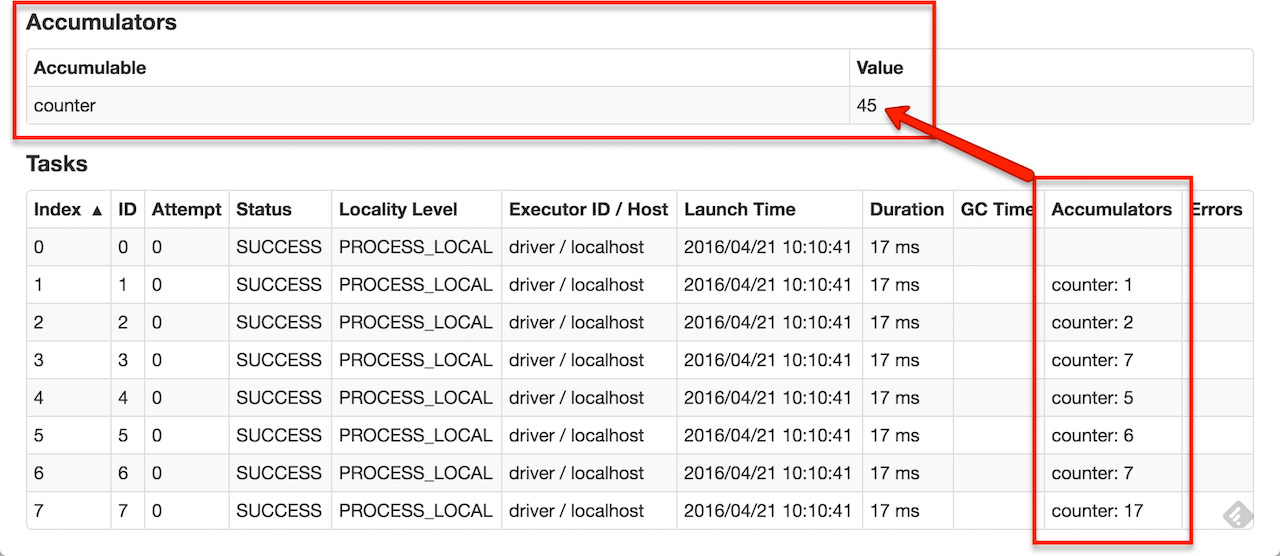

Tracking accumulators in the UI can be useful for understanding the progress of running stages (NOTE: this is not yet supported in Python).

An accumulator is created from an initial value v by calling SparkContext.accumulator(v). Tasks running on a cluster can then add to it using the add method or the += operator. However, they cannot read its value. Only the driver program can read the accumulator’s value, using its value method.

The code below shows an accumulator being used to add up the elements of an array:

In [84]:
accum = sc.accumulator(0)
accum

Accumulator<id=0, value=0>

In [85]:
sc.parallelize([1, 2, 3, 4]).foreach(lambda x: accum.add(x))

In [87]:
accum.value

10

In [91]:
accum = sc.accumulator(0)
rdd = sc.parallelize([1,2,3,4])
def f(x):
    global accum
    accum += x
rdd.foreach(f)    
accum.value

10